In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os

In [2]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)
torch.backends.cudnn.benchmark = True

cuda:0


In [3]:
runs_list = next(os.walk('./Data/Images'))[1]

In [4]:
path = "./Data/Labels.csv"
header = ['Run','AD']
Labelsdf = pd.read_csv(path, names=header, usecols=[1,2], skiprows=1, index_col=False)

In [5]:
labels_dict = dict(zip(Labelsdf.Run, Labelsdf.AD))

In [42]:
import re

# BASELINE RGB
img_dir = "./Data/Images"
low_bound = 100
high_bound = 200
img_scale = 1
depth_scale = 33
#list of tuples (image data, AD)
train_data, valid_data, test_data = [], [], []
for run in runs_list:
    run_dir = os.path.join(img_dir, run)
    run_imgs = []
    for filename in os.listdir(run_dir):
        img_num = int(filename[-7:-4])
        if (100 <= img_num < 199):
            img_slice = cv2.imread(os.path.join(run_dir, filename), cv2.IMREAD_GRAYSCALE)
            #print(img_slice)
            #img_slice = cv2.resize(img_slice, (0,0), fx=1/img_scale, fy=1/img_scale, interpolation=cv2.INTER_AREA)
            img_slice = img_slice[40:216,:]
            img_slice = img_slice/256
            run_imgs.append(img_slice)

    temp_arr = np.array(run_imgs)
    
    if temp_arr.size == 0 or not temp_arr.shape[1] == 176 or not temp_arr.shape[2] == 176:
        #print(run)
        #print(temp_arr.shape)
        continue
    
    final_slices = []
    #print(temp_arr.shape[2])
    
    for y in range(temp_arr.shape[2]):
        xz_pane = temp_arr[:, :, y]
        scaled_xz = cv2.resize(xz_pane, (0, 0), fy=1/depth_scale, fx=1, interpolation=cv2.INTER_AREA)
        final_slices.append(scaled_xz)
    
    if not len(final_slices[0]) == 3:
        continue
    
    final_array = torch.from_numpy(np.dstack(final_slices)).float()
    #print(final_array.shape)
    run_tuple = (final_array, labels_dict[run])
    
    subject_regex = re.compile("OAS(?P<order>[0-9]+)")
    subject = subject_regex.search(run).group(1)
    
    if int(subject[-2]) < 6:
        train_data.append(run_tuple)
    elif 6 <= int(subject[-2]) <=7:
        valid_data.append(run_tuple)
    elif 8 <= int(subject[-2]) <= 9:
        test_data.append(run_tuple)
    
    
print("Number of data points in train dataset: {}".format(len(train_data)))
print("Number of data points in valid dataset: {}".format(len(valid_data)))
print("Number of data points in test dataset: {}".format(len(test_data)))

    

Number of data points in train dataset: 157
Number of data points in valid dataset: 51
Number of data points in test dataset: 47


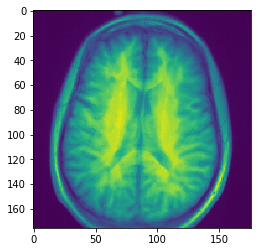

In [44]:
plt.imshow(valid_data[0][0][1])

In [45]:
from collections import Counter

counts = Counter(x[1] for x in train_data)
print("Number of non-AD scans in train dataset: {}".format(counts[0]))
print("Number of AD scan in train datasets: {}".format(counts[1]))
print("\n")

counts = Counter(x[1] for x in valid_data)
print("Number of non-AD scans in valid dataset: {}".format(counts[0]))
print("Number of AD scan in valid datasets: {}".format(counts[1]))
print("\n")

counts = Counter(x[1] for x in test_data)
print("Number of non-AD scans in test dataset: {}".format(counts[0]))
print("Number of AD scan in test datasets: {}".format(counts[1]))
print("\n")

Number of non-AD scans in train dataset: 131
Number of AD scan in train datasets: 26


Number of non-AD scans in valid dataset: 47
Number of AD scan in valid datasets: 4


Number of non-AD scans in test dataset: 38
Number of AD scan in test datasets: 9




In [46]:
old_train_data = train_data
train_AD = []
for item in train_data:
    if item[1] == 1:
        train_AD.append(item)
train_data = old_train_data + train_AD * 4

print("Number of data points in new train dataset: {}".format(len(train_data)))
counts = Counter(x[1] for x in train_data)
print("Number of non-AD scans in new train dataset: {}".format(counts[0]))
print("Number of AD scan in new train dataset: {}".format(counts[1]))

Number of data points in new train dataset: 261
Number of non-AD scans in new train dataset: 131
Number of AD scan in new train dataset: 130


In [47]:
from torch.utils.data import Dataset, DataLoader

class T1Dataset(Dataset):
    def __init__(self, data, transform=None):
        # list of tuples (3d image arrays, AD label)
        self.data = data
        # labels.csv
        #self.target = torch.from_numpy(target).long()
        #self.transform = transforms.Compose([transforms.ToTensor()])
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        #scan = torch.from_numpy(self.data[index][0]).float()
        scan = self.data[index][0]
        y = self.data[index][1]
        return scan, y

In [48]:
train_dataset = T1Dataset(train_data, None)
valid_dataset = T1Dataset(valid_data, None)
test_dataset = T1Dataset(test_data, None)

In [49]:
import torchvision.models

alexnet = torchvision.models.alexnet(pretrained=True)
alexnet.cuda()

train_dataset_list = list(train_dataset)
imgs, train_labels = next(iter(torch.utils.data.DataLoader(train_dataset_list, batch_size=len(train_dataset_list), shuffle=True)))
imgs = imgs.float()
imgs = imgs.to(device)
train_features = alexnet.features(imgs)

valid_dataset_list = list(valid_dataset)
imgs, valid_labels = next(iter(torch.utils.data.DataLoader(valid_dataset_list, batch_size=len(valid_dataset_list), shuffle=True)))
imgs = imgs.float()
imgs = imgs.to(device)
valid_features = alexnet.features(imgs)

test_dataset_list = list(test_dataset)
imgs, test_labels = next(iter(torch.utils.data.DataLoader(test_dataset_list, batch_size=len(test_dataset_list), shuffle=True)))
imgs = imgs.float()
imgs = imgs.to(device)
test_features = alexnet.features(imgs)

In [50]:
torch.max(imgs[43])

tensor(0.6754, device='cuda:0')

In [51]:
train_features_list = []
for i in range(train_features.shape[0]):
    train_features_list.append((train_features[i], train_labels[i]))
    
valid_features_list = []
for i in range(valid_features.shape[0]):
    valid_features_list.append((valid_features[i], valid_labels[i]))
    
test_features_list = []
for i in range(test_features.shape[0]):
    test_features_list.append((test_features[i], test_labels[i]))

In [117]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def get_loss(model, train=False):
    if train:
        data = train_features_list
    else:
        data = test_features_list
        
    loader = torch.utils.data.DataLoader(data, batch_size=len(data), shuffle=True)
    criterion = nn.BCEWithLogitsLoss()
    imgs, labels = next(iter(loader))
    imgs, labels = imgs.to(device), labels.to(device)
    out = model(imgs)             # forward pass
    loss = criterion(out, labels.float()) # compute the total loss
    return loss.item()

def get_accuracy(model, train=False):
    if train:
        data = train_features_list
    else:
        #data_acc_loader = torch.utils.data.DataLoader(data_val, batch_size=diff)
        data = valid_features_list

    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=32, shuffle=True):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs) # We don't need to run F.softmax
        corr = (outputs > 0.0).squeeze().long() == labels
        correct += int(corr.sum())
        #correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    #print(total)
    return correct / total

In [104]:
from torch.autograd import Variable

def train(model, features_list, num_epochs=10, batch_size=32, learning_rate=1e-4):
    criterion = nn.BCEWithLogitsLoss()
    # use Adam for CNN
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    epochs, train_losses, valid_losses, train_acc, valid_acc = [], [], [], [], []
    
    train_loader = torch.utils.data.DataLoader(features_list, batch_size=batch_size, shuffle=True)
    
    loss = 0
    
    for epoch in range(num_epochs):
        for inputs, labels in iter(train_loader):
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            #print(torch.sum(inputs))
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward(retain_graph=True)
            optimizer.step()
            #for param in model.parameters():
            #  print(param.grad.data.sum())
    
        epochs.append(epoch)
        train_losses.append(get_loss(model, train=True))
        valid_losses.append(get_loss(model, train=False))
        train_acc.append(get_accuracy(model, train=True))
        valid_acc.append(get_accuracy(model, train=False))
        
        print("Epoch %d; Train Loss %f; Val Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, valid_losses[-1], train_acc[-1], valid_acc[-1]))
    
    plt.title("Training Curve")
    plt.plot(epochs, train_losses, label="Train")
    plt.plot(epochs, valid_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(valid_acc[-1]))

In [105]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.name = "CNN2"
        # 256x6x6
        self.fc1 = nn.Linear(256*4*4, 512)
        nn.init.xavier_uniform(self.fc1.weight)
        #self.fc1 = nn.Linear(3*224*224, 512)
        self.fc2 = nn.Linear(512, 32)
        nn.init.xavier_uniform(self.fc2.weight)
        #self.fc3 = nn.Linear(512, 64)
        #nn.init.xavier_uniform(self.fc3.weight)
        self.fc3 = nn.Linear(32, 1)
        nn.init.xavier_uniform(self.fc3.weight)
        #self.softmax = nn.Softmax()

    def forward(self, x):
        x = x.view(-1, 256*4*4)
        #x = x.view(-1, 3*224*224)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = F.relu(self.fc2(x))
        #print(x.shape)
        x = F.relu(self.fc3(x))
        #print(x.shape)
        #x = self.fc4(x)
        #x = self.softmax(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [106]:
len(train_features_list)

261

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  


Epoch 1; Train Loss 0.692984; Val Loss 0.748508; Train Acc 0.628352; Val Acc 0.361702
Epoch 2; Train Loss 0.706752; Val Loss 0.751566; Train Acc 0.639847; Val Acc 0.361702
Epoch 3; Train Loss 0.689400; Val Loss 0.780731; Train Acc 0.609195; Val Acc 0.234043
Epoch 4; Train Loss 0.600873; Val Loss 0.767445; Train Acc 0.670498; Val Acc 0.361702
Epoch 5; Train Loss 0.647143; Val Loss 0.796663; Train Acc 0.628352; Val Acc 0.297872
Epoch 6; Train Loss 0.620617; Val Loss 0.788569; Train Acc 0.678161; Val Acc 0.319149
Epoch 7; Train Loss 0.586102; Val Loss 0.819886; Train Acc 0.651341; Val Acc 0.276596
Epoch 8; Train Loss 0.529172; Val Loss 0.814404; Train Acc 0.693487; Val Acc 0.297872
Epoch 9; Train Loss 0.467563; Val Loss 0.823130; Train Acc 0.697318; Val Acc 0.297872
Epoch 10; Train Loss 0.653570; Val Loss 0.839731; Train Acc 0.666667; Val Acc 0.319149
Epoch 11; Train Loss 0.673272; Val Loss 0.803855; Train Acc 0.750958; Val Acc 0.404255
Epoch 12; Train Loss 0.579199; Val Loss 0.798680; Tr

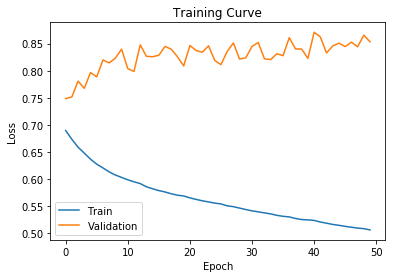

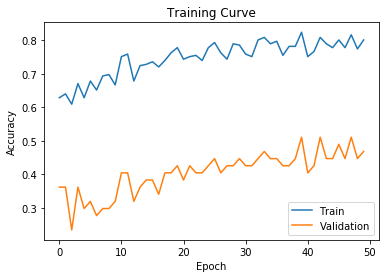

Final Training Accuracy: 0.8007662835249042
Final Validation Accuracy: 0.46808510638297873


In [107]:
alexnetCNN2 = CNN2()
alexnetCNN2.cuda()
train(alexnetCNN2, train_features_list, num_epochs=50, batch_size=32, learning_rate=1e-4)

In [84]:
for param in alexnetCNN2.parameters():
    print(param.grad.data.sum())

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


In [118]:
get_accuracy(alexnetCNN2, train=False)

0.4117647058823529